In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Data Statistics:

In [0]:
# import os 
# train_data_folder = "/content/drive/My Drive/NN-ProjectC/Project_C1/Final/Training"
# data_count = 0
# for image in os.listdir(train_data_folder):
#   if not image.endswith(".jpg"):
#     print ("Class", image,":", len(os.listdir(os.path.join(train_data_folder, image))))
#   else:
#     data_count += 1

# print ("Total number of images: ", data_count)

In [0]:
# ! pip install split-folders

# import split_folders
# training_data_folder = "/content/drive/My Drive/NN-ProjectC/Project_C1/Final/Training"
# split_folders.ratio(training_data_folder, output = "train_val_noaug", seed=1337, ratio = (.7,.3))

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input


HEIGHT = 224
WIDTH = 224
input_tensor = Input(shape = (HEIGHT, WIDTH, 3))
base_model = VGG16(weights = 'imagenet', 
                      include_top = False, 
                      input_tensor = input_tensor)

# To see the models' architecture and layer names, run the following
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

TRAIN_DIR = train_data_folder = "/content/drive/My Drive/NN-ProjectC/Project_C1/train_val_noaug/train"
VAL_DIR = "/content/drive/My Drive/NN-ProjectC/Project_C1/train_val_noaug/val"
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )



train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE, class_mode = 'categorical')

validation_generator = train_datagen.flow_from_directory( VAL_DIR, 
                                                         target_size =(HEIGHT, WIDTH), 
                                                         batch_size = BATCH_SIZE, class_mode = 'categorical', shuffle = False) 


Found 625 images belonging to 5 classes.
Found 271 images belonging to 5 classes.


In [0]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

def get_callbacks():

   path_checkpoint ='checkpoint_keras'  
   log_dir='logs'
   
   callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                         monitor='val_loss',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         period=1)
   callback_early_stopping = EarlyStopping(monitor='val_loss',
                                           patience=5,
                                           verbose=1)
   callback_tensorboard = TensorBoard(log_dir=log_dir,
                                      histogram_freq=0,
                                      write_graph=False)
   callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          min_lr=1e-4,
                                          patience=3,
                                          verbose=1)

   callbacks = [callback_checkpoint, callback_tensorboard, callback_reduce_lr]

   return callbacks

from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    '''for layer in base_model.layers:
        layer.trainable = False
    '''
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = [0, 1, 2, 3, 4]
FC_LAYERS = [1024, 1024]
dropout = 0.25

'''finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))
'''
for layer in base_model.layers:
  layer.trainable = True

# for layer in base_model.layers:
#   print (layer, layer.trainable)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
# model.summary()

In [0]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

Epoch 1/300
33/78 [===========>..................] - ETA: 10s - loss: 0.7329 - acc: 0.7652
Epoch 00001: saving model to vgg16_model_weights.h5
78/78 [==============================] - 45s 578ms/step - loss: 0.3502 - acc: 0.8590 - val_loss: 0.7329 - val_acc: 0.7652
Epoch 2/300
33/78 [===========>..................] - ETA: 9s - loss: 0.6517 - acc: 0.7841
Epoch 00002: saving model to vgg16_model_weights.h5
78/78 [==============================] - 42s 541ms/step - loss: 0.4026 - acc: 0.8460 - val_loss: 0.6517 - val_acc: 0.7841
Epoch 3/300
33/78 [===========>..................] - ETA: 8s - loss: 0.5223 - acc: 0.8068
Epoch 00003: saving model to vgg16_model_weights.h5
78/78 [==============================] - 42s 539ms/step - loss: 0.3199 - acc: 0.8768 - val_loss: 0.5223 - val_acc: 0.8068
Epoch 4/300
33/78 [===========>..................] - ETA: 9s - loss: 0.5703 - acc: 0.7689
Epoch 00004: saving model to vgg16_model_weights.h5
78/78 [==============================] - 42s 540ms/step - loss: 0

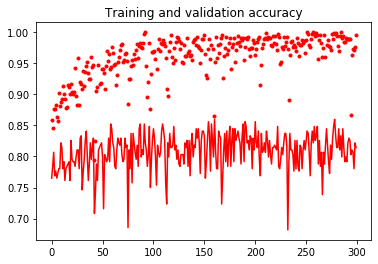

<Figure size 432x288 with 0 Axes>

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 100
BATCH_SIZE = 8
num_train_images = 625 
num_val_images = 271

adam = Adam(lr=0.0001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath = "vgg16" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["val_loss"], verbose=1, mode='max')
callbacks_list = get_callbacks()

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers = 8,
                                       steps_per_epoch = num_train_images // BATCH_SIZE,
                                       validation_data = validation_generator, 
                                       validation_steps = num_val_images// BATCH_SIZE,  
                                       shuffle = True, callbacks = [checkpoint])

# history = model.fit(train_generator, 
#                               epochs=NUM_EPOCHS,
#                               validation_data = validation_generator, 
#                               shuffle = True, 
#                               # batch_size = BATCH_SIZE,
#                               callbacks = callbacks_list)


plot_training(history)

